# 판매준비하기 AB test 분석

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, beta
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

# ✅ 전체 float 출력 포맷 소수점 4자리로 고정 (현재 세션에만 적용. python 다시 시작하면 다시 설정해줘야 함.)
pd.set_option('display.float_format', '{:.4f}'.format)

# Metric 별 통계 검정

- abtest_multi(groups, successes, trials, metric_name="") -> A,B,C 3group 이상인 경우 사용

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

def abtest_multi(groups, successes, trials, metric_name="Metric", samples=100_000):
    failures = trials - successes
    conversion_rates = successes / trials

    # ✅ metric_name 최상단 출력 (큰 제목)
    print("\n" + "#"*70)
    print(f"📊 {metric_name}\n" + "#"*70)
    
    
    # ✅ 그룹별 전환율 출력
    group_summary = pd.DataFrame({
        'Group': groups,
        'Successes': successes,
        'Trials': trials,
        'Conversion Rate': pd.Series(conversion_rates).map(lambda x: f"{x*100:.2f}%")
    })
    print("\n✅ Group Summary (Successes, Trials, Conversion Rate)")
    display(group_summary)
    print(f"\n{'='*60}")

    # for grp, rate in zip(groups, conversion_rates):
    #     print(f"{grp} group conversion rate: {rate:.2%}")

    # ✅ 전통적 통계검정: Chi-square test
    # Chi-square test
    contingency_table = np.array([successes, failures]).T
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    print("\n✅ Chi-square Test")
    print(f"- Chi2 statistic: {chi2:.4f}")
    print(f"- p-value: {p_value:.4f}")
    print(f"\n{'='*60}")



    # ✅ 사후 Pairwise Z-test (Holm-Bonferroni 보정)
    # 빈도주의 보수적 방식
    # Pairwise Z-test (Holm-Bonferroni)
    pairwise_results, pairs = [], []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            count = np.array([successes[i], successes[j]])
            nobs = np.array([trials[i], trials[j]])
            _, p = proportions_ztest(count, nobs)
            pairwise_results.append(p)
            pairs.append(f"{groups[i]} vs {groups[j]}")

    reject, pvals_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='holm')
    results_df = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (Holm)': pvals_corrected,
        'Significant': reject
    })
    print("\n✅ Pairwise Z-test (Holm-Bonferroni):")
    display(results_df)
    print(f"\n{'='*60}")



    # ✅ 사후 Pairwise Z-test (FDR 보정, 유연한 방식)
    # 빈도주의 유연한 방식
    # Pairwise Z-test (FDR)
    reject_fdr, pvals_fdr_corrected, _, _ = multipletests(pairwise_results, alpha=0.05, method='fdr_bh')
    results_df_fdr = pd.DataFrame({
        'Comparison': pairs,
        'Uncorrected p-value': pairwise_results,
        'Corrected p-value (FDR)': pvals_fdr_corrected,
        'Significant (FDR)': reject_fdr
    })
    print("\n✅ Pairwise Z-test (FDR - Benjamini-Hochberg):")
    display(results_df_fdr)
    print(f"\n{'='*60}")


    # 통계검정 값 고정하기 위한 random seed 고정
    # np.random.seed(42)  # 원하는 정수 사용 -> 베이지안 결과값 고정하기 위함 -> 랜덤 샘플의 시드 고정하는 코드

    # Bayesian analysis
    posterior_samples = {
        group: np.random.beta(1 + success, 1 + fail, samples)    
        for group, success, fail in zip(groups, successes, failures)
    }

    # ✅ Bayesian posterior 분포 시각화
    plt.figure(figsize=(12, 7))
    for group in groups:
        sns.kdeplot(posterior_samples[group], label=f'Group {group}')
    plt.title('Posterior Distributions of Conversion Rates', fontsize=16)
    plt.xlabel('Conversion Rate')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"\n{'='*60}")


    # ✅ Bayesian: 각 그룹이 가장 우수할 확률 계산
    best_group_count = {group: 0 for group in groups}
    for i in range(samples):
        best_group = max(posterior_samples, key=lambda g: posterior_samples[g][i])
        best_group_count[best_group] += 1

    print("\n✅ Bayesian: Probability that each group is best")
    for group, count in best_group_count.items():
        prob = count / samples
        print(f"Probability that {group} is the best: {prob:.2%}")
    print(f"\n{'='*60}")

    # ✅ Bayesian: 쌍별 우위 확률 계산
    # Bayesian pairwise superiority
    pairwise_bayes = []
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            g1, g2 = groups[i], groups[j]
            prob = np.mean(posterior_samples[g1] > posterior_samples[g2])
            pairwise_bayes.append({
                'Comparison': f"{g1} > {g2}",
                'P(Group1 > Group2)': prob,
                'P(Group1 < Group2)': 1 - prob
            })
    df_bayes = pd.DataFrame(pairwise_bayes)
    print("\n✅ Bayesian Pairwise Superiority Probabilities:")
    display(df_bayes)
    print(f"\n{'='*60}")



######################################################################
📊 My car to ReadyToSell Confirm CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,1741,31934,5.45%
1,B,1587,32265,4.92%
2,C,2162,32229,6.71%
3,D,3023,32035,9.44%




✅ Chi-square Test
- Chi2 statistic: 632.4641
- p-value: 0.0000


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0023,0.0023,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0023,0.0023,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True


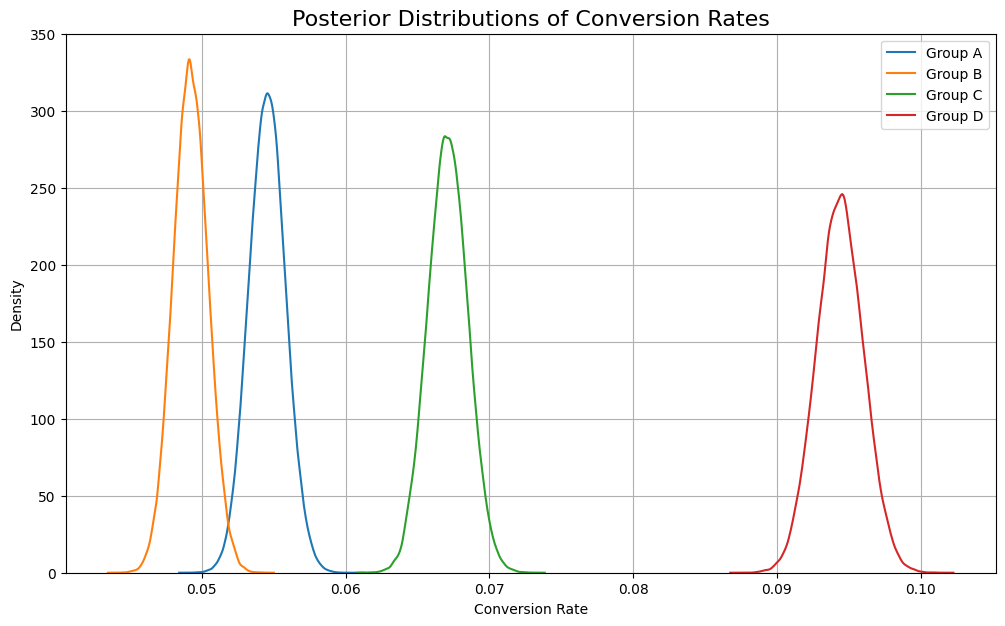



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 0.00%
Probability that C is the best: 0.00%
Probability that D is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.9989,0.0011
1,A > C,0.0000,1.0000
2,A > D,0.0000,1.0000
3,B > C,0.0000,1.0000
4,B > D,0.0000,1.0000
5,C > D,0.0000,1.0000




######################################################################
📊 My car to ReadyToSell Click CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3433,31934,10.75%
1,B,2808,32265,8.70%
2,C,5114,32229,15.87%
3,D,10045,32035,31.36%




✅ Chi-square Test
- Chi2 statistic: 7272.9508
- p-value: 0.0000


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True


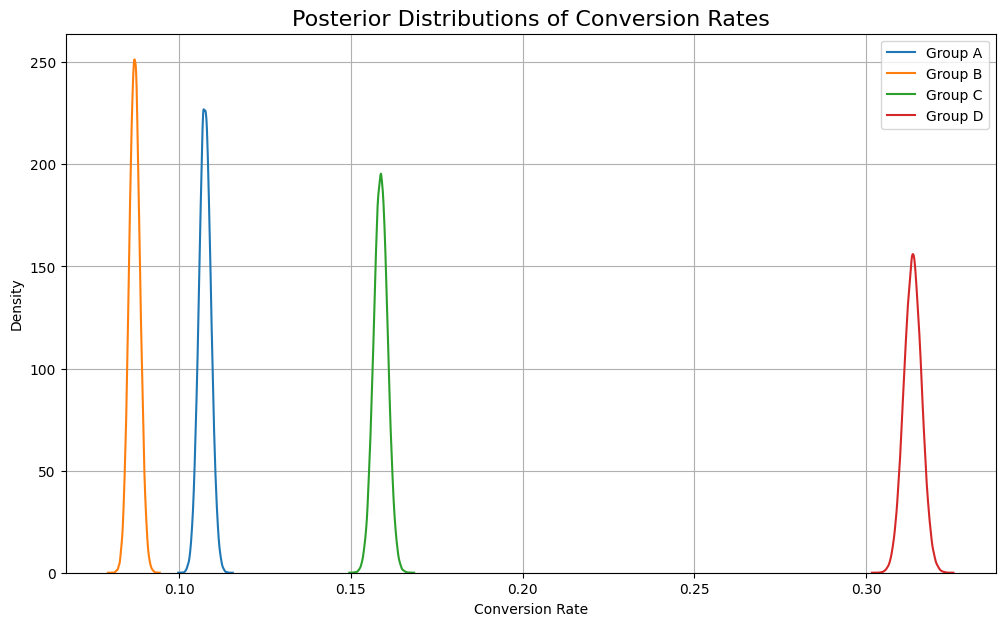



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 0.00%
Probability that C is the best: 0.00%
Probability that D is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000
1,A > C,0.0000,1.0000
2,A > D,0.0000,1.0000
3,B > C,0.0000,1.0000
4,B > D,0.0000,1.0000
5,C > D,0.0000,1.0000




######################################################################
📊 My car to ReadyToSell CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,2730,31934,8.55%
1,B,2213,32265,6.86%
2,C,3714,32229,11.52%
3,D,6689,32035,20.88%




✅ Chi-square Test
- Chi2 statistic: 3580.5878
- p-value: 0.0000


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.0000,0.0000,True
5,C vs D,0.0000,0.0000,True


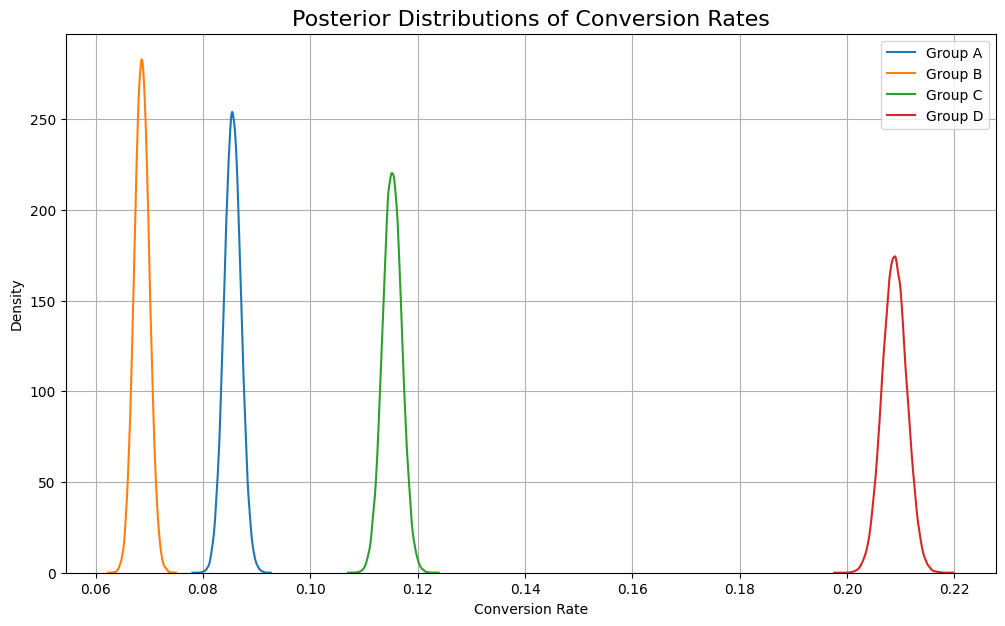



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 0.00%
Probability that C is the best: 0.00%
Probability that D is the best: 100.00%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,1.0000,0.0000
1,A > C,0.0000,1.0000
2,A > D,0.0000,1.0000
3,B > C,0.0000,1.0000
4,B > D,0.0000,1.0000
5,C > D,0.0000,1.0000




######################################################################
📊 My car to Request a Estimate Complete CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,3377,31934,10.57%
1,B,3667,32265,11.37%
2,C,3666,32229,11.37%
3,D,3669,32035,11.45%




✅ Chi-square Test
- Chi2 statistic: 16.4878
- p-value: 0.0009


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0014,0.0060,True
1,A vs C,0.0012,0.0060,True
2,A vs D,0.0004,0.0023,True
3,B vs C,0.9694,1.0000,False
4,B vs D,0.7261,1.0000,False
5,C vs D,0.7551,1.0000,False




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0014,0.0027,True
1,A vs C,0.0012,0.0027,True
2,A vs D,0.0004,0.0023,True
3,B vs C,0.9694,0.9694,False
4,B vs D,0.7261,0.9061,False
5,C vs D,0.7551,0.9061,False


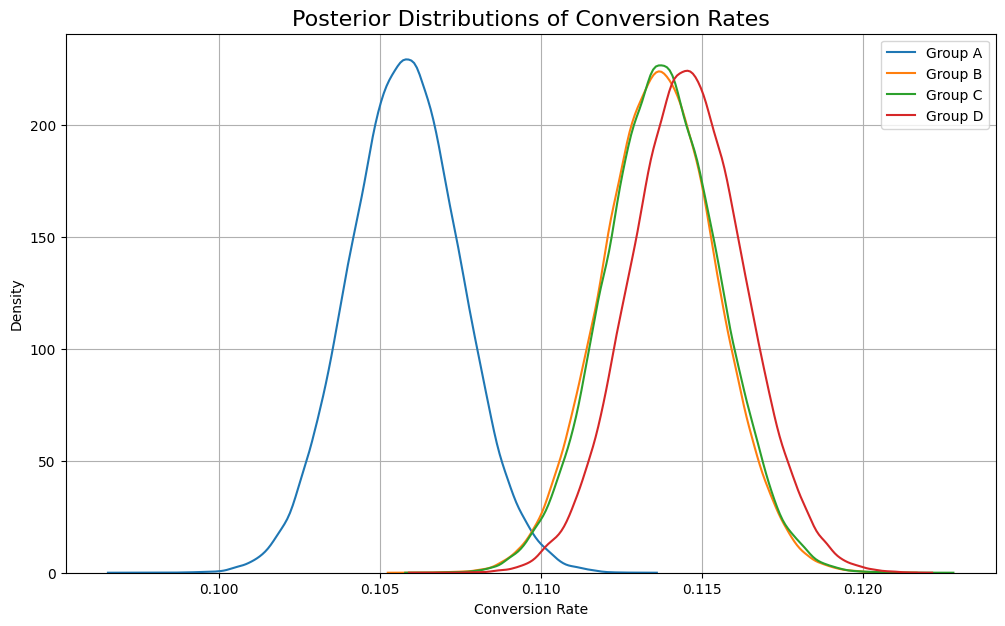



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 25.51%
Probability that C is the best: 27.42%
Probability that D is the best: 47.07%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0007,0.9993
1,A > C,0.0007,0.9993
2,A > D,0.0002,0.9998
3,B > C,0.4856,0.5144
4,B > D,0.3643,0.6357
5,C > D,0.3782,0.6218




######################################################################
📊 My car to Request a Estimate Click 1 CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,12254,31934,38.37%
1,B,13832,32265,42.87%
2,C,12978,32229,40.27%
3,D,13644,32035,42.59%




✅ Chi-square Test
- Chi2 statistic: 178.3222
- p-value: 0.0000


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.4745,0.4745,False
5,C vs D,0.0000,0.0000,True




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0000,0.0000,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0000,0.0000,True
4,B vs D,0.4745,0.4745,False
5,C vs D,0.0000,0.0000,True


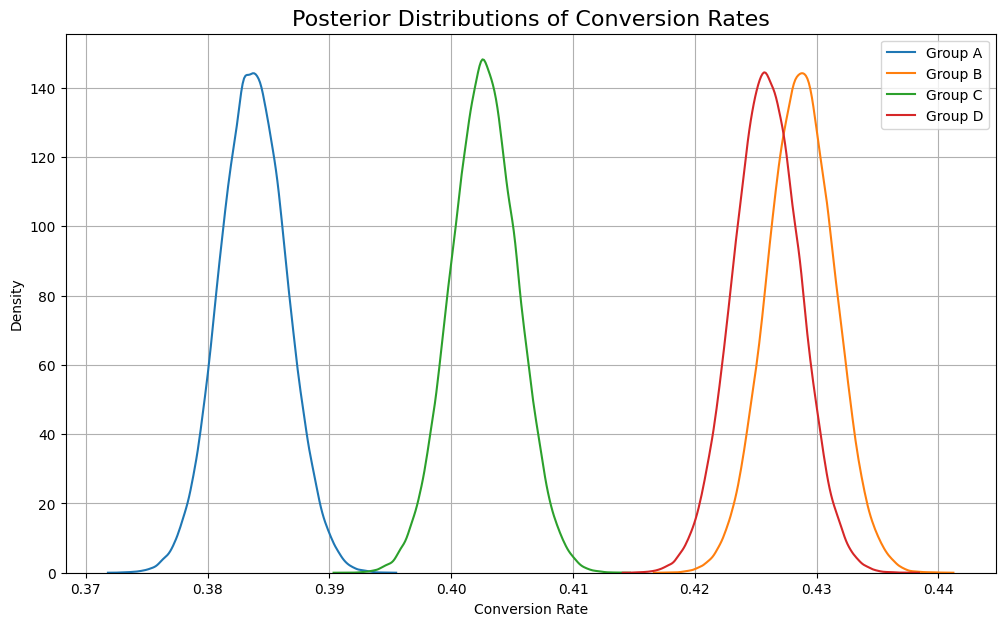



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 76.47%
Probability that C is the best: 0.00%
Probability that D is the best: 23.53%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000
1,A > C,0.0000,1.0000
2,A > D,0.0000,1.0000
3,B > C,1.0000,0.0000
4,B > D,0.7647,0.2353
5,C > D,0.0000,1.0000




######################################################################
📊 My car to Request a Estimate Click 2 CVR
######################################################################

✅ Group Summary (Successes, Trials, Conversion Rate)


,Group,Successes,Trials,Conversion Rate
0,A,7420,31934,23.24%
1,B,8251,32265,25.57%
2,C,7836,32229,24.31%
3,D,8331,32035,26.01%




✅ Chi-square Test
- Chi2 statistic: 81.3308
- p-value: 0.0000


✅ Pairwise Z-test (Holm-Bonferroni):


,Comparison,Uncorrected p-value,Corrected p-value (Holm),Significant
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0013,0.0027,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0002,0.0007,True
4,B vs D,0.2092,0.2092,False
5,C vs D,0.0000,0.0000,True




✅ Pairwise Z-test (FDR - Benjamini-Hochberg):


,Comparison,Uncorrected p-value,Corrected p-value (FDR),Significant (FDR)
0,A vs B,0.0000,0.0000,True
1,A vs C,0.0013,0.0016,True
2,A vs D,0.0000,0.0000,True
3,B vs C,0.0002,0.0003,True
4,B vs D,0.2092,0.2092,False
5,C vs D,0.0000,0.0000,True


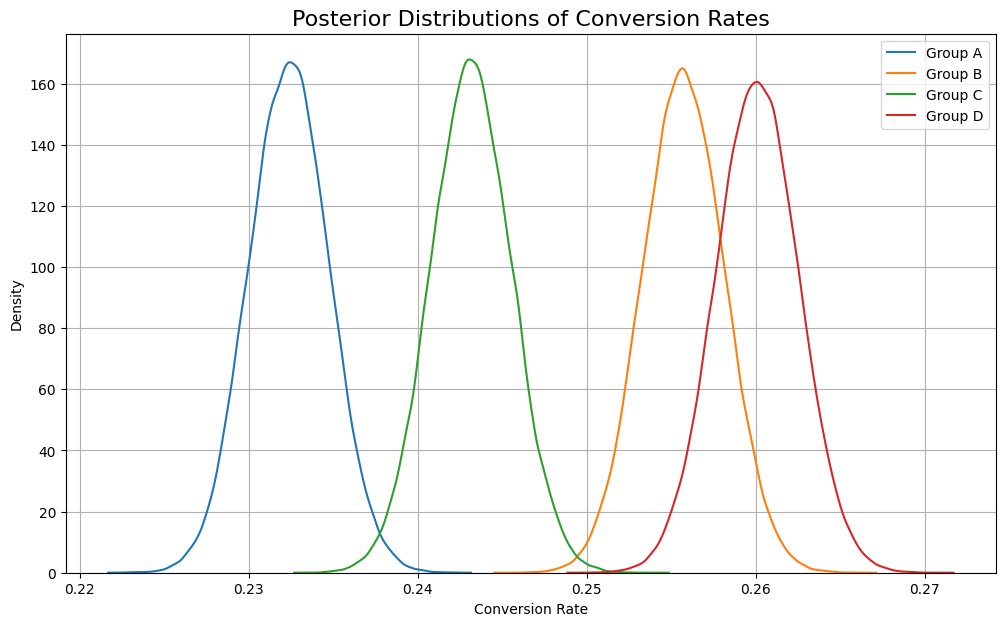



✅ Bayesian: Probability that each group is best
Probability that A is the best: 0.00%
Probability that B is the best: 10.51%
Probability that C is the best: 0.00%
Probability that D is the best: 89.49%


✅ Bayesian Pairwise Superiority Probabilities:


,Comparison,P(Group1 > Group2),P(Group1 < Group2)
0,A > B,0.0000,1.0000
1,A > C,0.0006,0.9994
2,A > D,0.0000,1.0000
3,B > C,0.9999,0.0001
4,B > D,0.1051,0.8949
5,C > D,0.0000,1.0000


In [13]:
# Test group 작성
groups = ['A', 'B', 'C', 'D']

# 각 이벤트 별 실험 결과 정리
CNT_TOTAL_PCID = np.array([33359, 33661, 33640, 33555])
CNT_MYCAR_HOME = np.array([33297, 33592, 33578, 33483])
CNT_MYCAR_HOME_ING = np.array([31934, 32265, 32229, 32035])
CNT_REQUEST_ESTIMATE_CLICK1 = np.array([12254, 13832, 12978, 13644])
CNT_REQUEST_ESTIMATE_CLICK2 = np.array([7420, 8251, 7836, 8331])
CNT_ESTIMATE_COMPLETE = np.array([3377, 3667, 3666, 3669])
CNT_READY_TO_SELL_CLICK = np.array([3433, 2808, 5114, 10045])
CNT_READY_TO_SELL_VIEW = np.array([2730, 2213, 3714, 6689])
CNT_READY_TO_SELL_CONFIRM = np.array([1741, 1587, 2162, 3023])
CNT_PRICE_CONFIRM = np.array([1018, 846, 1264, 1754])
CNT_PHOTO_CONFIRM = np.array([1331, 1223, 1527, 1611])
CNT_INFO_CONFIRM = np.array([687, 541, 994, 1868])
CNT_ESTIMATE_CONFIRM = np.array([41, 39, 49, 50])


# AB test 3그룹 이상 인 경우 abtest_multi() 사용
# abtest_multi(groups, successes, trials, metric_name="")
# Metric 별 작성

# Success Metric
# 1. 판매준비하기 정보 입력율
abtest_multi(groups, CNT_READY_TO_SELL_CONFIRM, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell Confirm CVR")
# 2. 내차고 홈 - 판매준비하기 클릭율
abtest_multi(groups, CNT_READY_TO_SELL_CLICK, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell Click CVR")
# 3. 판매준비하기 진입율
abtest_multi(groups, CNT_READY_TO_SELL_VIEW, CNT_MYCAR_HOME_ING, metric_name="My car to ReadyToSell CVR")

# Guardrail Metric
# 4. 비교견적 신청 전환율
abtest_multi(groups, CNT_ESTIMATE_COMPLETE, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Complete CVR")

# Sub Metric
# 5. 비교견적 신청 클릭율 1
abtest_multi(groups, CNT_REQUEST_ESTIMATE_CLICK1, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Click 1 CVR")
# 6. 비교견적 신청 클릭율 2 (서비스 선택 후 최종 신청 클릭)
abtest_multi(groups, CNT_REQUEST_ESTIMATE_CLICK2, CNT_MYCAR_HOME_ING, metric_name="My car to Request a Estimate Click 2 CVR")


In [14]:
1


1